In [1]:
library("deSolve")
library("ggplot2")

Warning message:
"package 'deSolve' was built under R version 3.6.2"Warning message:
"package 'ggplot2' was built under R version 3.6.2"

In [626]:
K_g = 1 # 0.7-1.2 confirmed
H_g = 250 # 1 was confirmed, but it was shit

K_gL = K_g/10
H_gL = H_g

e = 5e-7 # confirmed
K_d = 0.01
H_d = H_g

K_a = 2e-7#2e-7 #2e-7 is confirmed
K_pd = 0#1e-9 #random number

B = 50 #confirmed

d = 0.00

In [678]:
# functions for ODE solving here

monod <- function(S, Ks){ # since it gets called a lot 
  return (S/(Ks+S))
}


f <- function(t, y, params){ # Main ODE system
  G = y[1]
  R = y[2]
  P = y[3]
  L = y[4]
  L2 = y[5]
  P2 = y[6]
    
  i = params[1]
  P_lys = params[2]
  r = params[3]
  P_lys_2 = params[4]
  r2 = params[5]
  
  N = K_g*G*monod(R,H_g)  
  NL = K_gL*L*monod(R,H_gL) 
  NL2 = K_gL*L2*monod(R,H_gL)

  N_lys = P_lys*K_a*P*G
  N_lyt = (1-P_lys)*K_a*P*G
  
  N_lys_2 = P_lys_2*K_a*P2*G
  N_lyt_2 = (1-P_lys_2)*K_a*P2*G
  
  dGdt = N - K_d*G*(1-monod(R, H_g)) - K_a*P*G - d*G #new bacterial growth - deaths - new phage binds
  dLdt = NL - K_d*L*(1-monod(R, H_g)) + N_lys - r*L - d*L #new lysogen growth + new lysogens - deaths - inductions  #- K_d*L*(1-monod(R, H_g))

  if(monod(R,H_g) >2e-1) {
    L2_inductions =  r2*L2}
  else{
    L2_inductions = 0}
    
  dL2dt = NL2 - K_d*L2*(1-monod(R,H_g)) +N_lys_2 - L2_inductions - d*L2

    
  dPdt =  B*N_lyt + B*r*L - K_a*P*(G+0.01*(L+L2)) - K_pd*P -d*P# lyses + inductions - new binds - phage deaths (supposed to be G+L)
  dP2dt = B*N_lyt_2 + B*L2_inductions - K_a*P2*(G+0.01*(L+L2))-K_pd*P2 - d*P2
    
  dRdt = -e*(N+NL+NL2) + i -d*R#depleted by new growth, add exogenous

  temp <- c(dGdt, dRdt, dPdt, dLdt,dL2dt, dP2dt)
  L = list(temp)
  
  return(list(temp))
}


In [685]:
# Playing with the model here. 
out = data.frame()

# Let the population grow to its normal equilibrium size
times <- seq(0,to=400,by=0.1)
initials <- c(G=1, R=100, P=1, L = 0, L2=0, P2=1)
out_1 <- as.data.frame(ode(func=f,y=initials,parms = c(i=10, P_lys=0.01, r=0.01, P_lys_2=0.01, r2=0.01),times=times))
out <- rbind(out, out_1)

In [691]:
# Give the population some new resources
Q = length(out$time)
times <- seq(out$time[Q],to=out$time[Q]+400,by=1)
initials <- c(G=out$G[Q], R=out$R[Q], P = out$P[Q], L=out$L[Q], L2= out$L2[Q], P2=out$P2[Q])
out_1 <- as.data.frame(ode(func=f,y=initials,parms = c(i=0.1, P_lys=0.01, r=0.01, P_lys_2=0.01, r2=0.01),times=times))
out <- rbind(out, out_1)

In [692]:
# Give the population some new resources
Q = length(out$time)
times <- seq(out$time[Q],to=out$time[Q]+200,by=1)
initials <- c(G=out$G[Q]+1e+9, R=out$R[Q]+100, P = out$P[Q], L=out$L[Q], L2= out$L2[Q], P2=out$P2[Q])
out_1 <- as.data.frame(ode(func=f,y=initials,parms = c(i=10, P_lys=0.01, r=0.01, P_lys_2=0.01, r2=0.01),times=times))
out <- rbind(out, out_1)

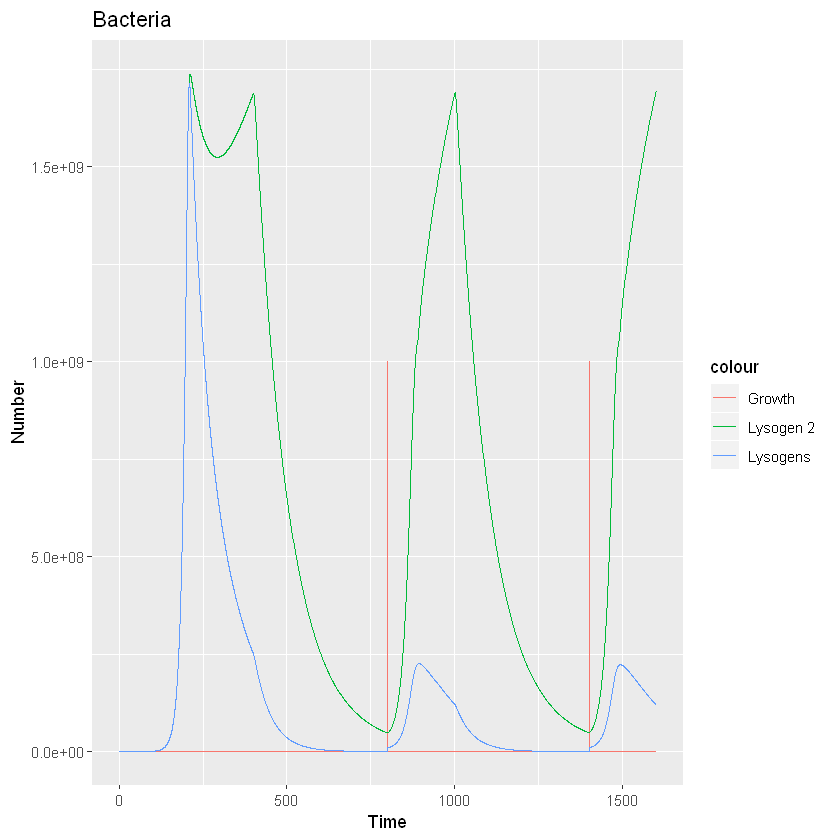

In [693]:
ggplot(out, aes(time))+geom_line(aes(y=G, color='Growth')) +geom_line(aes(y=L2, color='Lysogen 2'))+geom_line(aes(y=L, color='Lysogens'))  + labs(title='Bacteria', x='Time', y='Number') 

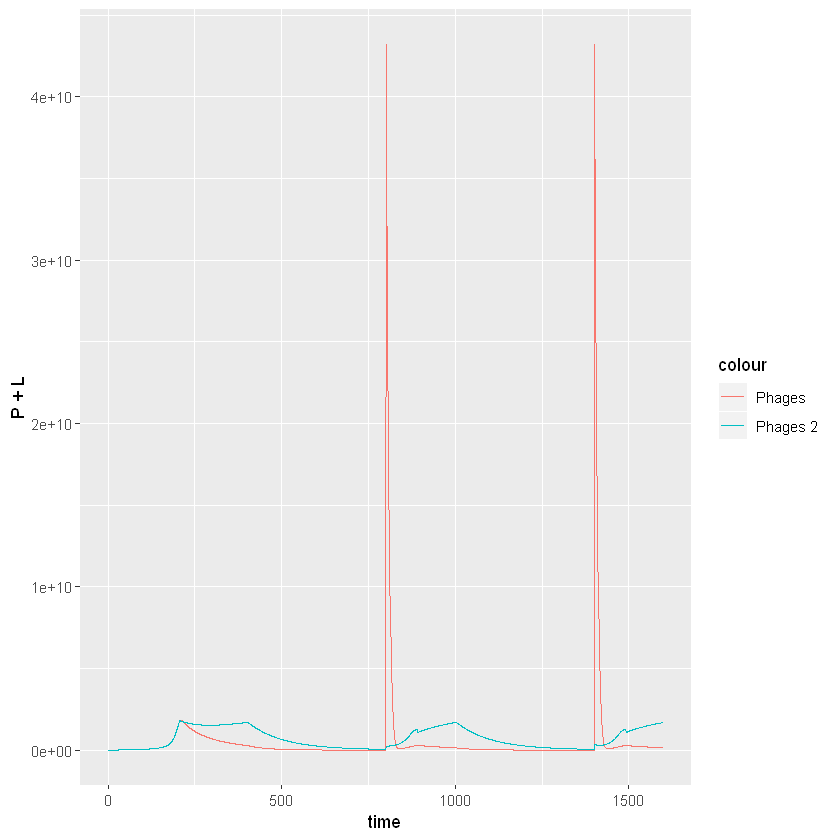

In [694]:
ggplot(out, aes(time))+geom_line(aes(y=P+L,color='Phages'))+geom_line(aes(y=P2+L2,color='Phages 2'))

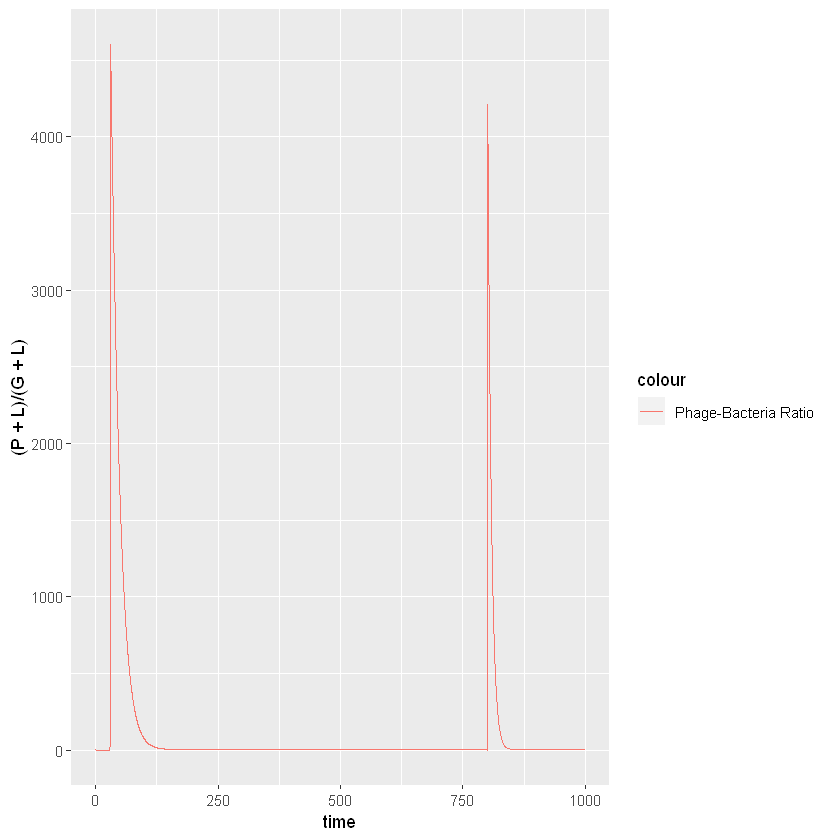

In [684]:
ggplot(out, aes(time))+geom_line(aes(y=(P+L)/(G+L),color='Phage-Bacteria Ratio'))

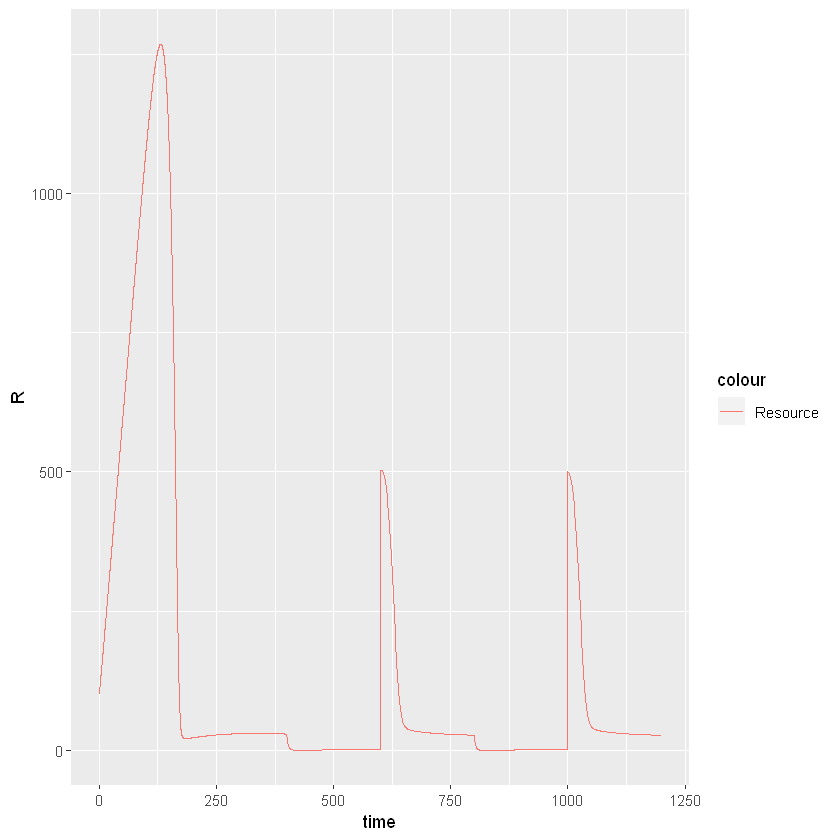

In [561]:
ggplot(out, aes(time))+geom_line(aes(y=R,color='Resource'))


equilibrium <- function(state, dt, unchangable_params){
    Len = length(state$time)
    new_times = seq(state$time[Len],to=state$time[Len]+dt,by=0.1)
    initials = c(G=state$G[Len], R=state$R[Len], P = state$P[Len]*0.99, L = state$L[Len]*0.99, L2 = state$L[Len]*0.01, P2 =  state$P[Len]*0.01)
   
    best_exploit <- function(initial_params){
        total_phage = function(new_params){
            P_lys_2 = new_params[1]
            r2 = new_params[2]
            all_params =  c(unchangable_params['i'], initial_params['P_lys'],unchangable_params['r'],new_params['P_lys_2'],unchangable_params['r2'])
            integrated = as.data.frame(ode(func=f,y=initials,parms=all_params,times=new_times))

            total_beginning_phage = initials['L2'] + initials['P2']
            Len_int = length(integrated$time)
            total_end_phage = integrated$L2[Len_int]+integrated$P2[Len_int]
            phage_increase = total_end_phage/total_beginning_phage
            return(-1*phage_increase)
        }
        optimized = optim(par=c(P_lys_2=0.5), fn=total_phage,method = "L-BFGS-B", gr=NULL, lower = c(0), upper=c(1))
        print(optimized$par)
        return(-1*optimized$value) #maximal exploitability
    }
    print(best_exploit(c(P_lys=0.9)))
    
    #optimized = optim(par=c(P_lys=0.3), fn=best_exploit,method = "L-BFGS-B", gr=NULL, lower = c(0), upper=c(1))

    }

equilibrium(state=out, dt = 20, unchangable_params= c(i=10, r=0.01, r2=0.01))


state=out
dt=1
unchangable_params=c(i=10, r=0.01)

    Len = length(state$time)
    new_times = seq(state$time[Len],to=state$time[Len]+dt,by=0.1)
    initials = c(G=state$G[Len], R=state$R[Len], P = state$P[Len], L = state$L[Len], L2 = 0, P2 = 0)
   
    best_exploit <- function(){
        total_phage = function(new_params){
            all_params =  c(unchangable_params['i'], new_params['P_lys'],unchangable_params['r'],P_lys_2=0, r2=0)
            integrated = as.data.frame(ode(func=f,y=initials,parms=all_params,times=new_times))

            total_beginning_phage = initials['L'] + initials['P']
            Len_int = length(integrated$time)
            total_end_phage = integrated$L[Len_int]+integrated$P[Len_int]
            phage_increase = total_end_phage/total_beginning_phage
            return(-1*phage_increase)
        }
        optimized = optim(par=c(P_lys=0.3), fn=total_phage,method = "L-BFGS-B", gr=NULL, lower = c(0), upper=c(1))
        print(optimized$par)
        return(-1*optimized$value) #maximal exploitability
    }
    print(best_exploit())
